[*********************100%***********************]  4 of 4 completed
/var/folders/8p/1m9zyky932sf40mmykhp6sl40000gn/T/ipykernel_2856/2931799032.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (individual_vols[i], mean_returns[i]), xytext=(10,0),


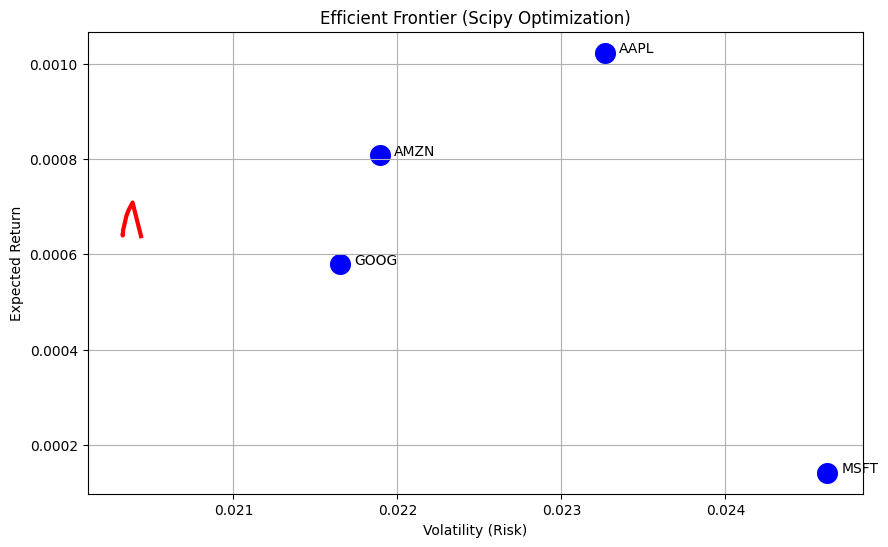


Optimal Portfolio Weights:
AAPL: 25.08%
MSFT: 12.07%
GOOG: 34.93%
AMZN: 27.92%


In [22]:
!pip install yfinance numpy pandas matplotlib scipy

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Get stock data - FIXED VERSION
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Close']  # Changed from 'Adj Close' to 'Close'

# 2. Calculate returns and covariance matrix
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 3. Portfolio optimization functions
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def optimize_portfolio(mean_returns, cov_matrix, risk_aversion=1.0):
    num_assets = len(mean_returns)
    
    def objective(weights):
        portfolio_return = np.dot(mean_returns, weights)
        portfolio_risk = portfolio_volatility(weights, cov_matrix)
        return - (portfolio_return - risk_aversion * portfolio_risk)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.array([1/num_assets] * num_assets)
    
    result = minimize(objective, init_guess, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x

# 4. Calculate efficient frontier
risk_levels = np.logspace(-2, 2, 20)
efficient_portfolios = []

for risk in risk_levels:
    weights = optimize_portfolio(mean_returns, cov_matrix, risk_aversion=risk)
    ret = np.dot(mean_returns, weights)
    vol = portfolio_volatility(weights, cov_matrix)
    efficient_portfolios.append((vol, ret))

# 5. Plot results
frontier = np.array(efficient_portfolios)
plt.figure(figsize=(10,6))
plt.plot(frontier[:,0], frontier[:,1], 'r-', linewidth=3)
plt.title('Efficient Frontier (Scipy Optimization)')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.grid(True)

# Add individual assets
individual_vols = np.sqrt(np.diag(cov_matrix))
plt.scatter(individual_vols, mean_returns, marker='o', s=200, color='blue')
for i, txt in enumerate(tickers):
    plt.annotate(txt, (individual_vols[i], mean_returns[i]), xytext=(10,0), 
                textcoords='offset points')
plt.show()

# Show optimal weights
optimal_weights = optimize_portfolio(mean_returns, cov_matrix, risk_aversion=1)
print("\nOptimal Portfolio Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")